In [1]:
import copy
import os
import pathlib

In [2]:
from drmdp import dataproc

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

In [4]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/drmdp/workflows/controljob/agg/1741970754/1742078665/metrics/*.parquet")

In [5]:
df_metrics = dataproc.read_data(files)

Metadata Fetch Progress 0:   0%|                                                                              …

2025-03-16 00:55:35,253	INFO worker.py:1564 -- Connecting to existing Ray cluster at address: 127.0.0.1:6379...
2025-03-16 00:55:35,259	INFO worker.py:1740 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Parquet Files Sample 0:   0%|                                                                                 …

Read progress 0:   0%|                                                                                        …

In [6]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,340,1741970754-029b5608-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[51.15115174683992, 52.18940581222031, 12.0875...","{'returns': {'mean': 38.47602594096943, 'std':...",PP/IMR
1,340,1741970754-02b10a43-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[46.622094115962426, 47.20144178600493, 49.226...","{'returns': {'mean': 47.68323861816496, 'std':...",OP-S/FR
2,340,1741970754-038ddee0-Finite-CC-SCIM-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[58.742963557140776, 55.5691670254954, 54.0094...","{'returns': {'mean': 56.10720716686537, 'std':...",PP/IMR
3,340,1741970754-03ea0ab6-GridWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[-104.63636363636364, -101.99120234604105, -12...","{'returns': {'mean': -110.94428152492668, 'std...",PP/FR
4,340,1741970754-049e601c-Finite-CC-PMSM-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[846.542507898157, 847.6003079865739, 790.3456...","{'returns': {'mean': 828.1628234584192, 'std':...",OP-S/FR
...,...,...,...,...,...,...
26995,80,1741970754-f93f1eb5-RedGreen-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[-98.72839506172839, -109.27160493827161, -120...","{'returns': {'mean': -109.35390946502058, 'std...",OP-S/FR
26996,80,1741970754-fa444c30-Finite-CC-PMSM-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[1678.9839598163007, 1662.6394739065547, 1645....","{'returns': {'mean': 1662.4378196759062, 'std'...",PP/LEAST-LFA
26997,80,1741970754-fd17bfd5-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[-41.864197530864196, -37.407407407407405, -41...","{'returns': {'mean': -40.17695473251029, 'std'...",OP-A/FR
26998,80,1741970754-fe97a7c4-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174197075...","[-36.30864197530864, -37.77777777777778, -33.7...","{'returns': {'mean': -35.93004115226338, 'std'...",PP/IMR


In [7]:
envs = dataproc.get_distinct_envs(df_metrics)

In [8]:
envs

{'Finite-TC-PermExDc-v0': {'max_episode_steps': 1000.0,
  'penalty_gamma': 1.0,
  'pos_enforcement': True,
  'violation_reward': 0.0},
 'Finite-CC-SCIM-v0': {'max_episode_steps': 1000.0,
  'penalty_gamma': 1.0,
  'pos_enforcement': True,
  'violation_reward': 0.0},
 'GridWorld-v0': None,
 'Finite-CC-PMSM-v0': {'max_episode_steps': 1000.0,
  'penalty_gamma': 1.0,
  'pos_enforcement': True,
  'violation_reward': 0.0},
 'MountainCar-v0': {'max_episode_steps': 2500.0,
  'penalty_gamma': None,
  'pos_enforcement': None,
  'violation_reward': None},
 'IceWorld-v0': None,
 'RedGreen-v0': None,
 'Finite-TC-ShuntDc-v0': {'max_episode_steps': 1000.0,
  'penalty_gamma': 1.0,
  'pos_enforcement': True,
  'violation_reward': 0.0},
 'Finite-CC-SeriesDc-v0': {'max_episode_steps': 1000.0,
  'penalty_gamma': 1.0,
  'pos_enforcement': True,
  'violation_reward': 0.0}}

In [9]:
def parse_delay_config(df_input: pd.DataFrame):
    df = copy.deepcopy(df_input)
    def parse_mu(delay_config):
        if delay_config is None:
            return None
        args = delay_config["args"]
        try:
            return args["delay"]
        except KeyError:
            return args["lam"]
        except KeyError as exc:
            raise ValueError(f"Unknown delay config {args}") from exc
    df["delay_type"] = df["delay_config"].apply(lambda dc: dc["name"] if dc else None)
    df["delay_mu"] = df["delay_config"].apply(parse_mu)
    del df["delay_config"]
    return df

In [10]:
def create_returns_plotting_data(
    df_data: pd.DataFrame,
):
    methods = sorted(df_data["method"].unique())
    methods_palette = {
        method: color for method, color,  in zip(methods, sns.color_palette())
    }
    df_result = copy.deepcopy(df_data)
    for key in ("delay_config", "gamma",):
        df_result[key] = df_result["meta"].apply(lambda meta: meta["problem_spec"][key])    
    for key in ("name", "args"):
        df_result[f"env_{key}"] = df_result["meta"].apply(lambda meta: meta["env_spec"][key])
    
    del df_result["meta"]

    df_result = parse_delay_config(df_result)
    df_baseline = df_result[pd.isnull(df_result["delay_type"])]
    df_result = df_result[~pd.isnull(df_result["delay_type"])]
    baseline_dfs = []
    distinct_algo_configs = df_result[["delay_type", "delay_mu"]].drop_duplicates()

    # Replicate baseline results for each config
    # to make plotting easier.
    for row in distinct_algo_configs.to_dict("records"):
        print(row)
        df_baseline_rp = copy.deepcopy(df_baseline)
        # reward period is one
        df_baseline_rp["delay_type"] = row["delay_type"]
        df_baseline_rp["delay_mu"] = row["delay_mu"]
        baseline_dfs.append(df_baseline_rp)
    df_result = pd.concat(baseline_dfs + [df_result], axis=0)
    df_result = df_result.sort_values(["method", "delay_type", "delay_mu"])
    
    # agg returns
    df_result["mean_returns"] = df_result["returns"].apply(lambda returns: np.mean(returns))
    return {"sarsa": df_result}

In [11]:
df_returns_curves = create_returns_plotting_data(df_metrics)

{'delay_type': 'fixed', 'delay_mu': 2.0}
{'delay_type': 'fixed', 'delay_mu': 4.0}


In [12]:
df_returns_curves["sarsa"]

,episode,exp_id,returns,metrics,method,gamma,env_name,env_args,delay_type,delay_mu,mean_returns
7,340,1741970754-0b6c6a3c-IceWorld-v0,"[-36.87976539589443, -35.469208211143695, -36....","{'returns': {'mean': -36.44672531769306, 'std'...",OP-A/FR,1.0,IceWorld-v0,None,fixed,2.0,-36.446725
10,340,1741970754-115d6883-RedGreen-v0,"[-35.63049853372434, -38.85923753665689, -35.2...","{'returns': {'mean': -36.565982404692086, 'std...",OP-A/FR,1.0,RedGreen-v0,None,fixed,2.0,-36.565982
12,340,1741970754-14f6bb31-Finite-TC-ShuntDc-v0,"[241.1617597398227, 375.30152604143353, 238.21...","{'returns': {'mean': 284.89422370172093, 'std'...",OP-A/FR,1.0,Finite-TC-ShuntDc-v0,"{'max_episode_steps': 1000.0, 'penalty_gamma':...",fixed,2.0,284.894224
24,340,1741970754-2096b330-RedGreen-v0,"[-37.47507331378299, -34.98240469208211, -36.6...","{'returns': {'mean': -36.36656891495601, 'std'...",OP-A/FR,1.0,RedGreen-v0,None,fixed,2.0,-36.366569
33,340,1741970754-422f1f40-Finite-TC-PermExDc-v0,"[58.997145709073955, 56.95547832677739, 58.470...","{'returns': {'mean': 58.141053806460945, 'std'...",OP-A/FR,1.0,Finite-TC-PermExDc-v0,"{'max_episode_steps': 1000.0, 'penalty_gamma':...",fixed,2.0,58.141054
...,...,...,...,...,...,...,...,...,...,...,...
26966,80,1741970754-9f587ab6-Finite-TC-ShuntDc-v0,"[264.6724134682041, 263.3333453541443, 257.863...","{'returns': {'mean': 261.95651228433076, 'std'...",PP/LEAST-LFA,1.0,Finite-TC-ShuntDc-v0,"{'max_episode_steps': 1000.0, 'penalty_gamma':...",fixed,4.0,261.956512
26969,80,1741970754-a828c288-Finite-TC-PermExDc-v0,"[48.47430235956511, 47.99463580071909, 46.6065...","{'returns': {'mean': 47.69181520655214, 'std':...",PP/LEAST-LFA,1.0,Finite-TC-PermExDc-v0,"{'max_episode_steps': 1000.0, 'penalty_gamma':...",fixed,4.0,47.691815
26988,80,1741970754-df39278b-Finite-CC-SCIM-v0,"[1691.1722605016585, 1693.644365838081, 1700.3...","{'returns': {'mean': 1695.0482351198298, 'std'...",PP/LEAST-LFA,1.0,Finite-CC-SCIM-v0,"{'max_episode_steps': 1000.0, 'penalty_gamma':...",fixed,4.0,1695.048235
26996,80,1741970754-fa444c30-Finite-CC-PMSM-v0,"[1678.9839598163007, 1662.6394739065547, 1645....","{'returns': {'mean': 1662.4378196759062, 'std'...",PP/LEAST-LFA,1.0,Finite-CC-PMSM-v0,"{'max_episode_steps': 1000.0, 'penalty_gamma':...",fixed,4.0,1662.437820


In [13]:
df_returns_curves["sarsa"]["method"].unique()

array(['OP-A/FR', 'OP-S/FR', 'PP/FR', 'PP/IMR', 'PP/LEAST-LFA'],
      dtype=object)

In [14]:
def export_figure(
    figure, name: str, format: str = "pdf", dpi=300, transparent: bool = True
):
    # to be able to save, we must plot
    base_dir = os.path.dirname(name)
    if not os.path.exists(base_dir):
        tf.io.gfile.makedirs(base_dir)
    figure.savefig(f"{name}.{format}", dpi=dpi, format=format, transparent=transparent)

In [15]:
MARKERS = ["s", "p", "o", "P", "X", "d"]

In [16]:
DASHES = {
    "PP/FR": (1, 0),
    "PP/IMR": (1, 1),
    "PP/LEAST-LFA": (2, 1),
    "OP-A/FR": (6, 2),
    "OP-S/FR": (6, 3), 
}

In [17]:
METHODS_PALETTES = {
    key: palette for key, palette in zip(
        ["PP/FR", "PP/IMR", "PP/LEAST-LFA", "OP-A/FR", "OP-S/FR"],
        sns.color_palette()
    )
}

In [18]:
sorted(df_returns_curves["sarsa"]["env_name"].unique())

['Finite-CC-PMSM-v0',
 'Finite-CC-SCIM-v0',
 'Finite-CC-SeriesDc-v0',
 'Finite-TC-PermExDc-v0',
 'Finite-TC-ShuntDc-v0',
 'GridWorld-v0',
 'IceWorld-v0',
 'MountainCar-v0',
 'RedGreen-v0']

In [19]:
SHORT_NAMES = {
    "Finite-CC-PMSM-v0": "CC-PMSM",
    "Finite-CC-SCIM-v0": "CC-SCIM",
    "Finite-CC-SeriesDc-v0": "CC-SeriesDc",
    "Finite-TC-PermExDc-v0": "TC-PermExDc",
    "Finite-TC-ShuntDc-v0": "TC-ShuntDc",
    "GridWorld-v0": "GW",
    "IceWorld-v0": "IW",
    "MountainCar-v0": "MC",
    "RedGreen-v0": "RGS",
}

In [20]:
def plot_eval_result(
    env: str,
    gamma: float,
    df_data: pd.DataFrame,
    suffix: str,    
    max_episode: int = np.inf,
    max_reward_period: int = 8,
    output_dir: str = "figures/returnplots"
):
    df_data = df_data[suffix]
    methods = sorted(df_data["method"].unique())
    filter_mask = (
        (df_data["env_name"] == env) &
        (df_data["gamma"] == gamma) & 
        (df_data["episode"] <= max_episode) &
        (df_data["delay_mu"] <= max_reward_period)
    )
    df_result = copy.deepcopy(df_data[filter_mask])
    def rename_env(env: str):
        try:
            return SHORT_NAMES[env]
        except KeyError:
            return env
                               
    df_result["name"] = df_result["env_name"].apply(rename_env)
    del df_result["mean_returns"]
    df_result = df_result.explode("returns")
    
    df_result = df_result.rename(
        {
            "delay_mu": "P", 
            "episode": "Episode",
            "returns": "Avg Returns",
            "method": "Method"
        }, 
        axis=1
    )
    # split to give flexibility in plotting
    name_prefix = "_".join(
        [str(token) for token in ["rc", env, gamma]]
    )

    facet_grid = sns.relplot(
        data=df_result, x="Episode", y="Avg Returns",
        col="P",
        hue="Method",
        style="Method",
        kind="line",
        palette=METHODS_PALETTES,
        errorbar="sd",
        height=2,
        dashes=DASHES
    )
    title_template = ", ".join([f"{rename_env(env)}", "P = {col_name}"])
    facet_grid.set_titles(title_template)
    export_figure(facet_grid.figure, os.path.join(output_dir, f"{name_prefix}_{suffix}"))
    plt.show()

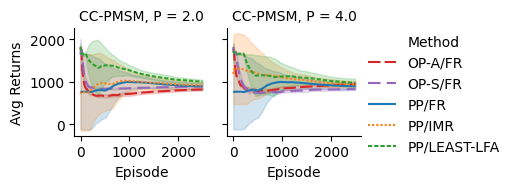

In [21]:
plot_eval_result(
    env="Finite-CC-PMSM-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

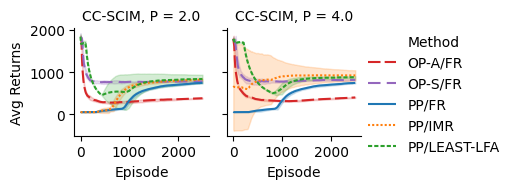

In [22]:
plot_eval_result(
    env="Finite-CC-SCIM-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

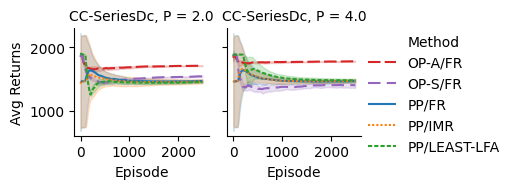

In [23]:
plot_eval_result(
    env="Finite-CC-SeriesDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

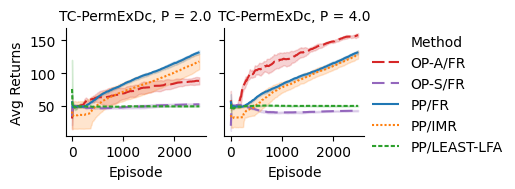

In [24]:
plot_eval_result(
    env="Finite-TC-PermExDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

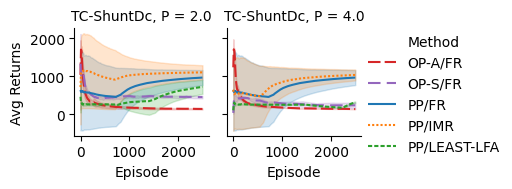

In [25]:
plot_eval_result(
    env="Finite-TC-ShuntDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

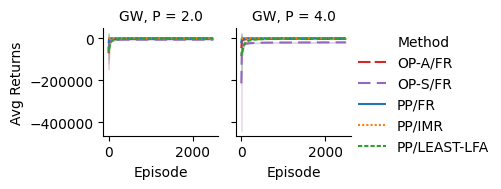

In [26]:
plot_eval_result(
    env="GridWorld-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

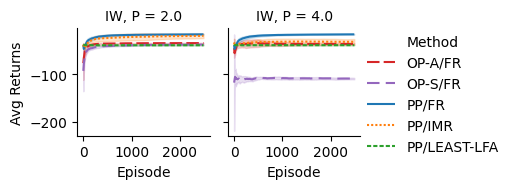

In [27]:
plot_eval_result(
    env="IceWorld-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

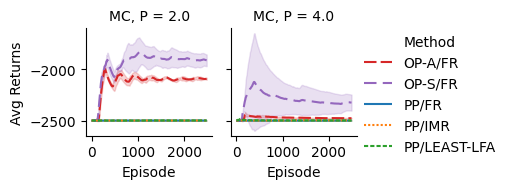

In [28]:
plot_eval_result(
    env="MountainCar-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

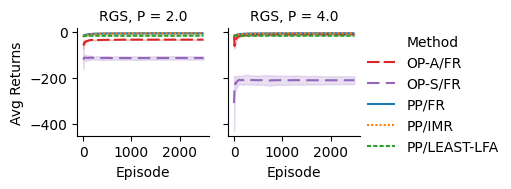

In [29]:
plot_eval_result(
    env="RedGreen-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)